In [1]:
import pandas as pd 
import numpy as np
import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import utils

In [2]:
batch = '2024_02_06_Batch_8'
pipeline = 'profiles_tcdropped_filtered_var_mad_outlier_featselect'

In [3]:
type_col = 'Metadata_node_type'
gene_col = 'Metadata_symbol'
var_col = 'Metadata_gene_allele'

In [4]:
# Choose Gene to plot UMAP for
gene_name = 'DIABLO'
use_protein_feat = 'non-protein'

In [5]:
data_dir = f"../6.downstream_analysis_snakmake/outputs/batch_profiles/{batch}"
result_dir = f"../6.downstream_analysis_snakmake/outputs/results/{batch}/{pipeline}"
sc_profiles_path = f"{data_dir}/{pipeline}.parquet"

In [6]:
sc_profiles = pd.read_parquet(sc_profiles_path)
sc_profiles, var_num_filtered = utils.filter_common_genes(sc_profiles, node_type_col=type_col, gene_col=gene_col, var_col=var_col)
sc_profiles = utils.remove_nan_infs_columns(sc_profiles)

This batch contains 1030 variants from 173 genes, and 338 references. The overlap between ref and var is 171.
After filtering, there are 1021 variants left.


In [7]:
hit_var = pd.read_csv(f'outputs/data/{batch}_hit.csv')

In [8]:
if use_protein_feat == 'protein':
    feature_col = utils.get_protein_features(sc_profiles, True)
elif use_protein_feat == 'non-protein':
    feature_col = utils.get_protein_features(sc_profiles, False)
else: use_protein_feat = find_feat_cols(sc_profiles)

In [9]:
gene_profiles = sc_profiles[sc_profiles[gene_col]==gene_name].reset_index(drop=True)
gene_profiles.loc[np.where(
    gene_profiles['Metadata_gene_allele']==gene_profiles['Metadata_symbol']
)[0], 'Metadata_gene_allele'] = 'Reference'

In [10]:
# Fit on both reference and variants
reducer = umap.UMAP(n_neighbors=15, n_components=2)
embeddings = reducer.fit_transform(gene_profiles[feature_col])
aux = pd.concat((pd.DataFrame(embeddings, columns=["X", "Y"]), gene_profiles.reset_index()), axis=1)

In [11]:
hit_var['Group2'] = hit_var['Group2'].apply(lambda x: '_'.join(x.split('_')[1:]))
aux['Hit'] = aux['Metadata_gene_allele'].apply(lambda x: True if x in list(hit_var.Group2.unique()) else False)

In [12]:
ref = aux[aux['Metadata_gene_allele']=='Reference']
var = aux[aux['Metadata_gene_allele']!='Reference']
var_hit = var[var['Hit']]
var_nothit = var[~var['Hit']]

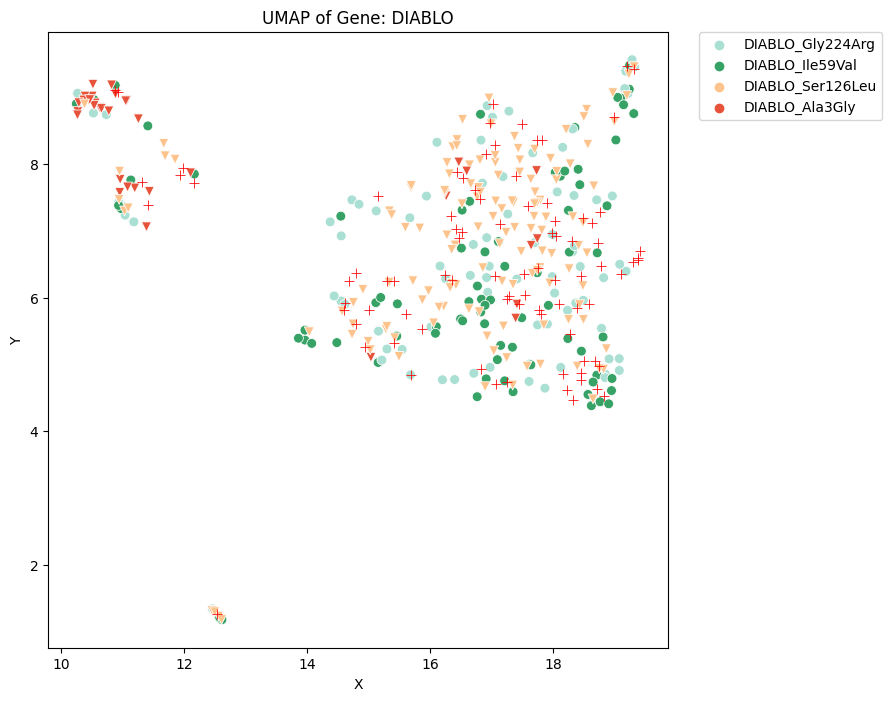

In [13]:
# UMAP of protein features - before sphering
plt.figure(figsize=(8,8))


b = sb.scatterplot(data=var_nothit, x="X", y="Y", s=50, hue='Metadata_gene_allele', palette='BuGn')
c = sb.scatterplot(data=var_hit, x="X", y="Y", s=50, hue='Metadata_gene_allele', palette='OrRd', marker='v')
a = sb.scatterplot(data=ref, x="X", y="Y", s=50, color='red', marker='+')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(f'UMAP of Gene: {gene_name}')
plt.savefig(f'outputs/figures/{batch}/{gene_name}_umap_{use_protein_feat}.png', bbox_inches='tight')
plt.show()